In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#non complex model
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pickle
import matplotlib.pyplot as plt

from scipy.signal import find_peaks, peak_widths

import cvnn.layers as complex_layers

import joblib 

from numpy import linalg as LA

def nmrs (pred_np,y_tst):
    x=LA.norm(y_tst-pred_np)/LA.norm(y_tst-np.mean(y_tst))
    return x


In [2]:
#Loading data from csv

data = pd.read_csv('C:/Users/alamg/Desktop/Thesis_ML/graphene/data_absorbance.csv')
data_np= np.array(data)
data_500 = pd.read_csv('C:/Users/alamg/Desktop/Thesis_ML/graphene/data_500.csv')
data_raw=np.array(data_500)

In [4]:
#Extracting absorbance, s11 and x parameter from the csv by reading each data row by row and appending to the lists
data_abs=[]
data_s11=[]
data_param=[]
flag=0
#reshaping the data for better usebility
for j in range(0,len(data_raw),50):
    row=[]
    row2=[]
    value3= data_raw[flag,0:3]
    data_param.append(value3)
    for i in range(0,50,1):
        absob = data_raw[flag,5]
        s11= data_raw[flag,4]
        row.append(absob)
        row2.append(s11)
        flag=flag+1
    data_abs.append(row)
    data_s11.append(row2)

In [6]:
#defining datatypes
data_s11=np.array(data_s11,dtype='complex64')
data_abs=np.array(data_abs,dtype='float64')
data_param=np.array(data_param,dtype='float32')

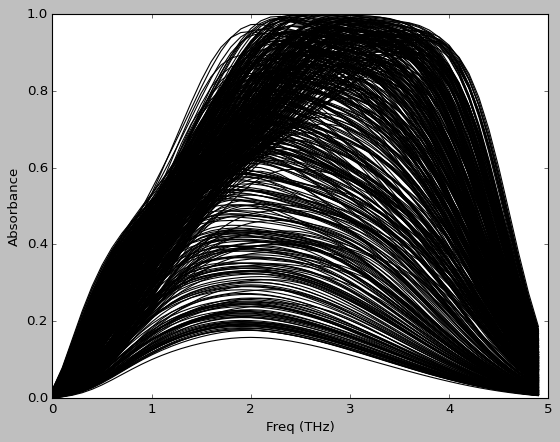

In [8]:
#plotting data to see if it has been loaded correctly 

freq=np.arange(0,5,0.1) #plaotting original data for verification
with plt.style.context('classic'): #sanity check if correct waveforms are loaded
    plt.plot(freq,data_abs[:,:].T,label='complex', color='black')
  #  plt.plot(w1,data_abs[0,:],label='complex', color='blue')
   #plt.plot(w1,Y[1,:], label='absorbance')
#  plt.plot(w1,Y[2,:], color='green')
 #   plt.plot(w1,Y[3,:], color='blue')
  #  plt.plot(w1,Y[4,:], color='red')
    #plt.plot(w3,y_2p_wav[1,:])
    plt.xlabel("Freq (THz)")
    plt.ylabel("Absorbance")
    plt.show()
   # plt.legend()

In [9]:
#getting peaks, amplitude and half width of each wave

data_pk=[] # to store peaks
data_am=[] # to store amplitude
data_qf=[] # to store width of peak which will be later used to calculate quality factor
pos=[] #storing position of each peak for later filtering peaks data from unfiltered list
d_m=[] #discarded peaks index
d_m2=[] #2 peaks store on this index, these are not discarded, we will only take the peak with higest amplitude and consider it as one peak

#getting peaks and saving discarded points
for i in range(len(data_abs)):
    peaks, _ = find_peaks(data_abs[i,:],height=0.5) 
    if len(peaks)==1:
        data_pk.append(peaks)
        data_am.append(data_abs[i,(peaks)])
        j = peak_widths(data_abs[i,:], peaks, rel_height=0.5)
        data_qf.append(j[0])
        pos.append(i)
    elif len(peaks)==2:
        data_pk.append(peaks)
        data_am.append(data_abs[i,(peaks)])
        j = peak_widths(data_abs[i,:], peaks, rel_height=0.5)
        data_qf.append(j[0])
        pos.append(i)
        d_m2.append(i)
    else:
        d_m.append(i)

In [10]:
#routine to store physical params of filtered data, so we take the index of the peaks that have been filtered and save their x data

i=0
j=0
k=0
x_data = pd.DataFrame()
#getting data for each peak response by taking X as different pos values for each 1,2,3 peak response
for i in range(0,len(pos)):
    j = pos[i]
    k = pd.DataFrame({"B":data_param[j,0],"W":data_param[j,1],"Ef":data_param[j,2]},index=[i])
    x_data = pd.concat([x_data, pd.DataFrame(k)], ignore_index=True)

In [11]:
#routine to store feature data of the filtered peaks, we take data_pk calculated previously, 
#data_am for amplitude and data_pk/data_qf to get qualitfy factor, so we take peak position and divide by its width

i=0
m=0
j=0
y_data = pd.DataFrame()
y_data_abs = []
#getting data for each peak response by taking y as different pos values for each 1,2,3 peak response
for i in range(0,len(pos)):
    j=pos[i]
    m = pd.DataFrame({"Peak":data_pk[i][0],"Amp":data_am[i][0],"Q-Factor":(data_pk[i][0]/data_qf[i][0])},index=[i])
    y_data = pd.concat([y_data, pd.DataFrame(m)], ignore_index=True)
    y_data_abs.append(data_abs[j,:])

In [12]:
#converting pandas DF to numpy array for easier manupulation in NN
y_data=np.array(y_data) #y_data is features data
x_data=np.array(x_data) #x_data is for parameter
y_data_abs = np.array(y_data_abs) #y_data_abs is for absorbance 

In [ ]:
#Splitting data for both models 

scaler = MinMaxScaler()
X = scaler.fit_transform(data_param)
Y= scaler.fit_transform(y_data)


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=22)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=22)

In [ ]:
#RELU N.N


# Assuming X and Y are your feature and target matrices respectively
# Split the data into training and testing sets and naming them
X_train_m1 = X_train
X_test_m1 = X_test
X_val_m1 = X_val
y_val_m1 = y_val
y_train_m1= y_train
y_test_m1=y_test



# Create a Sequential model
model_1 = Sequential()

model_1.add(Dense(28, input_shape=(X.shape[1],), activation='relu'))  # Assuming 64 neurons in the first hidden layer

# Add additional hiden layers if needed
model_1.add(Dense(29, activation='relu'))  # Example of adding another hidden layer

# Add the output layer
model_1.add(Dense(Y.shape[1], activation='linear'))  # Assuming 5 design parameters, using linear activation

# Compile the model
model_1.compile(optimizer='adam', loss='mse')  # Using mean squared error as the loss function

# Print a summary of the model
model_1.summary()

#Early stopping 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

# Train the model
history = model_1.fit(X_train_m1, y_train_m1, epochs=5000, verbose=1, callbacks=[es], batch_size=32,validation_data=(X_val_m1, y_val_m1))

# Make predictions
predictions = model_1.predict(X_test_m1)  # Replace X_test with your actual test data
model_metric = nmrs(predictions,y_test_m1)
print(f'NMRSE: {model_metric}')



In [ ]:
#GELU N.N

def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    model.load_state_dict(torch.load(filename))
    
# Extract input and output data
# Convert to PyTorch tensors
X_train_m2 =  torch.tensor(X_train, dtype=torch.float32)
X_test_m2 =  torch.tensor(X_test, dtype=torch.float32)
X_val_m2 = torch.tensor(X_val, dtype=torch.float32)
y_val_m2 = torch.tensor(y_val, dtype=torch.float32)
y_train_m2= torch.tensor(y_train, dtype=torch.float32)
y_test_m2= torch.tensor(y_test, dtype=torch.float32)


# Define the neural network
class MyNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MyNeuralNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_size, hidden_sizes[0]),
            nn.GELU()
        ])
        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.extend([
                nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]),
                nn.GELU()
            ])
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

input_size = X.shape[1]
hidden_sizes = [28,29,31]  # Adjust the number of neurons and layers as needed
output_size = Y.shape[1]

# Create an instance of the neural network
model = MyNeuralNetwork(input_size, hidden_sizes, output_size)
print(model)
# Define loss function and optimizer
criterion = nn.MSELoss() # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=(0.0001)) # Adaptive Moment Estimation

    
# Training loop
num_epochs = 50000

early_stop_thresh = 170
best_loss = 1000
best_epoch = 5
 
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_m2)
    loss = criterion(outputs, y_train_m2)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    
# Make predictions on new data
    with torch.no_grad():
        new_data = X_val_m2.clone().detach().requires_grad_(True)
        val_predictions  = model(new_data)

# Evaluate the model on the validation set
    val_loss = criterion(val_predictions, y_val_m2)
    print(f'Validation MSE: {val_loss.item():.4f}')

    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch
        checkpoint(model,"best_model.pth")
        print(f'Epoch [{epoch+1}/{num_epochs}], Training MSE: {loss.item():.4f}')
    elif epoch-best_epoch > early_stop_thresh:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training MSE: {loss.item():.4f}')
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop
resume(model, "best_model.pth")



with torch.no_grad():
        new_data = X_test_m2.clone().detach().requires_grad_(True)
        test_predict  = model(new_data)
# Convert predictions to numpy array if needed
pred_gelu = test_predict.numpy() #predictions of model saved in pred_gelu 


# Evaluate the model on the test set
test_loss = criterion(test_predict, y_test_m2)
#print(f'Test MSE: {test_loss.item():.4f}')
model_matric = nmrs(pred_gelu,y_test)
print(f'NMRSE: {model_matric}')



In [ ]:
#for loading model and getting predictions instead of running the N.N above

#for loading RELU models
m1 = pickle.load(open('model_name.sav', 'rb')) 
Loaded_pred = m1(X_test) #giving the loaded model test data loaded above
Loaded_pred = Loaded_pred.numpy()


#for loading GELU models
x = pickle.load(open('model_name.sav', 'rb'))
with torch.no_grad(): #since GELU uses torch, we need to use this routine to load the model and feed the test data
        new_data = X_test_m2.clone().detach().requires_grad_(True) #x_test_m2 is torch datatype, if you get any error please convert the X_test to torch and run this 
        Loaded_pred_2 = x(new_data)
Loaded_pred_2 = Loaded_pred_2.numpy()


In [ ]:
#Boilerplate for printing of one feature results

#inverse transform of prediction and test data to get back real values from scaled data

pred_inv = scaler.inverse_transform(pred_gelu)
data_inv = scaler.inverse_transform(y_test)

w1=np.linspace(0,38,38) #38 is sample size of test after test/train split 

plt.scatter(w1,pred_inv,label="Model", marker='x', color="blue")
plt.scatter(w1,data_inv,label="Test Data",color="red")
plt.annotate("Model NMRSE = {:.4f}".format(nmrs(pred_inv,data_inv)), (25, 0.6))
plt.xlabel("Test Samples")
plt.ylabel("Quality Factor")
plt.legend(loc="upper right")
  #  axs[2].set_ylim(0.5, 1)
  # axs[2].set_title("1 Layer - 100 Neurons N.N")
plt.tight_layout()
#plt.savefig('3Model_Pred', bbox_inches='tight')
plt.show()

In [ ]:
#Boilerplate for printing of three feature results

#inverse transform of prediction and test data to get back real values from scaled data
pred_inv = scaler.inverse_transform(pred_gelu)
data_inv = scaler.inverse_transform(y_test)

w1=np.linspace(0,38,38)

with plt.style.context('ggplot'):#sanity check if correct waveforms are loaded
    fig, axs = plt.subplots(1, 3, figsize=(24, 10))
#plot for 3 features output
    axs[0].scatter(w1,pred_inv[:,0],label="Model",marker='x', color="green")
    axs[0].scatter(w1,data_inv[:,0],label="Test data",color="red") 
    axs[0].annotate("Model NMRSE = {:.4f}".format(nmrs(pred_inv[:,0],data_inv[:,0])), (0, 3.25 #define coordinate for nmrse results plotting))
    axs[0].set_xlabel("Test Samples")
    axs[0].set_ylabel("Freq THz")
    axs[0].legend(loc="upper left")


    axs[1].scatter(w1,pred_inv[:,1],label="Model", color="blue", marker='x')
    axs[1].scatter(w1,data_inv[:,1],label="Test Data",color="red")
    axs[1].annotate("Model NMRSE = {:.4f}".format(nmrs(pred_inv[:,1],data_inv[:,1])), (0, 0.95 #define coordinate for nmrse results plotting))
    axs[1].set_xlabel("Test Samples")
    axs[1].set_ylabel("Scaled - Peak Amplitude")
    axs[1].legend(loc="upper left")
    axs[1].set_title(" Predictions Feature Space")

    axs[2].scatter(w1,pred_inv[:,2],label="Model", marker='x', color="blue")
    axs[2].scatter(w1,data_inv[:,2],label="Test Data",color="red")
    axs[2].annotate("Model NMRSE = {:.4f}".format(nmrs(pred_inv[:,2],data_inv[:,2])), (0, 0.9 #define coordinate for nmrse results plotting))
    axs[2].set_xlabel("Test Samples")
    axs[2].set_ylabel("Scaled - Peak Q-Factor")
    axs[2].legend(loc="upper left")
    axs[2].set_title("Global NMRSE: = {:.4f}".format((nmrs(pred_inv[:,:],data_inv[:,:]))))

plt.tight_layout()
#plt.savefig('1000_Data_GeLU_2L_28N', bbox_inches='tight')
plt.show()

